This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray Rainbow5 backend

In this example, we read Rainbow5 data files using the wradlib `rainbow` xarray backend.

In [1]:
import glob
import gzip
import io
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()

/home/runner/micromamba-root/envs/wradlib-tests/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Rainbow5 Volume Data

In [2]:
fpath = "rainbow/2013051000000600dBZ.vol"
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_rainbow_dataset(f, reindex_angle=False)

### Inspect RadarVolume

In [3]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 14)
Elevation(s): (0.6, 1.4, 2.4, 3.5, 4.8, 6.3, 8.0, 9.9, 12.2, 14.8, 17.9, 21.3, 25.4, 30.0)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 14)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2013-05-10T00:00:06Z'
    time_coverage_end    <U20 '2013-05-10 00:03:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_13'
    sweep_fixed_angle    (sweep) float64 0.6 1.4 2.4 3.5 ... 17.9 21.3 25.4 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.6

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol[0])

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5492 1.505 2.549 ... 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    rtime              (azimuth) datetime64[ns] 2013-05-10T00:00:15.530303500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2013-05-10T00:00:06.015151500
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.6
Attributes:
    fixed_angle:  0.6

### Goereferencing

In [6]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

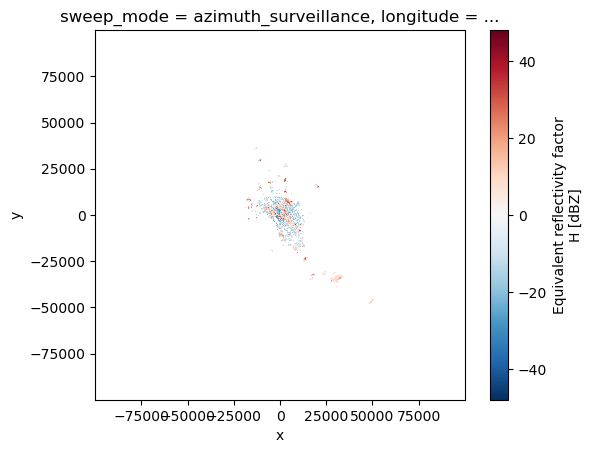

In [7]:
swp.DBZH.plot.pcolormesh(x="x", y="y")
pl.gca().set_aspect("equal")

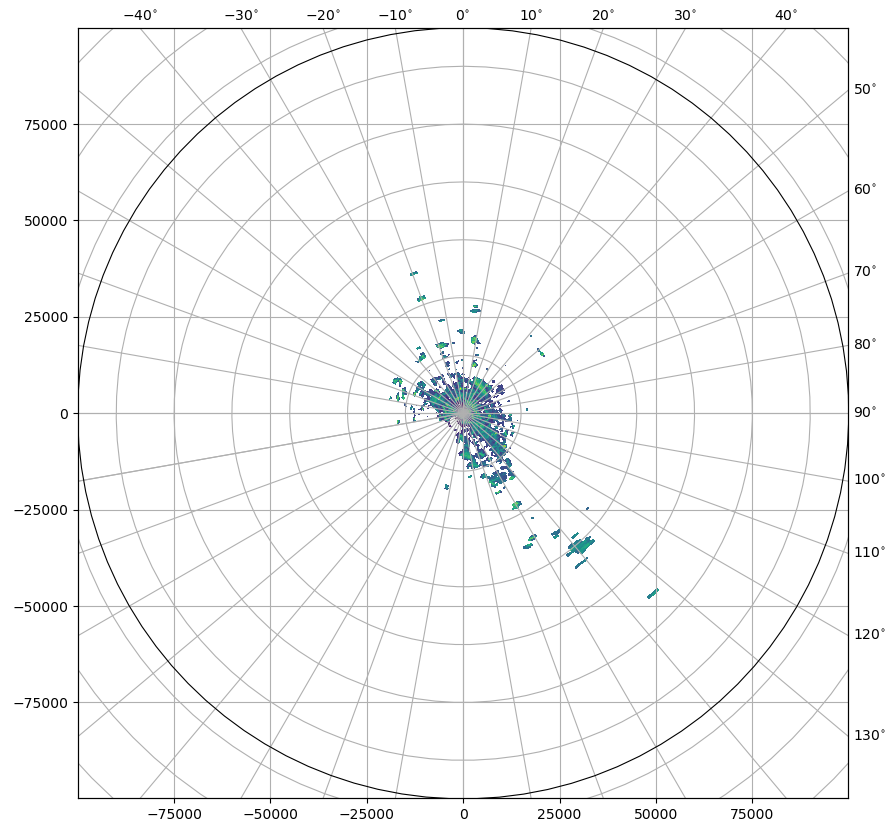

In [8]:
fig = pl.figure(figsize=(10, 10))
swp.DBZH.wradlib.plot_ppi(proj="cg", fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=6.379967 +lat_0=50.856633 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


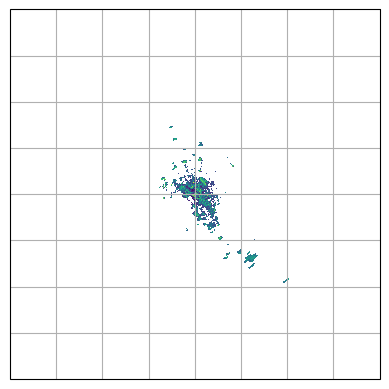

In [10]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

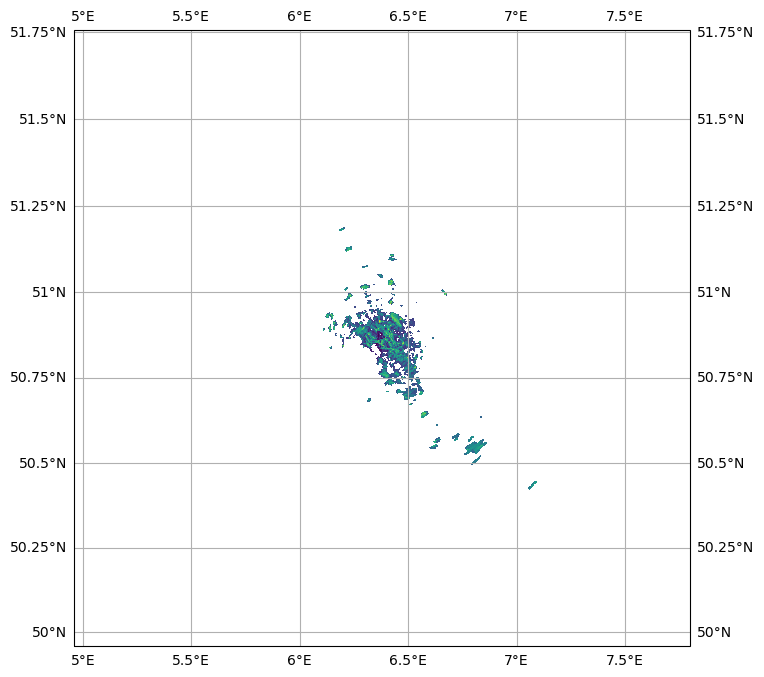

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

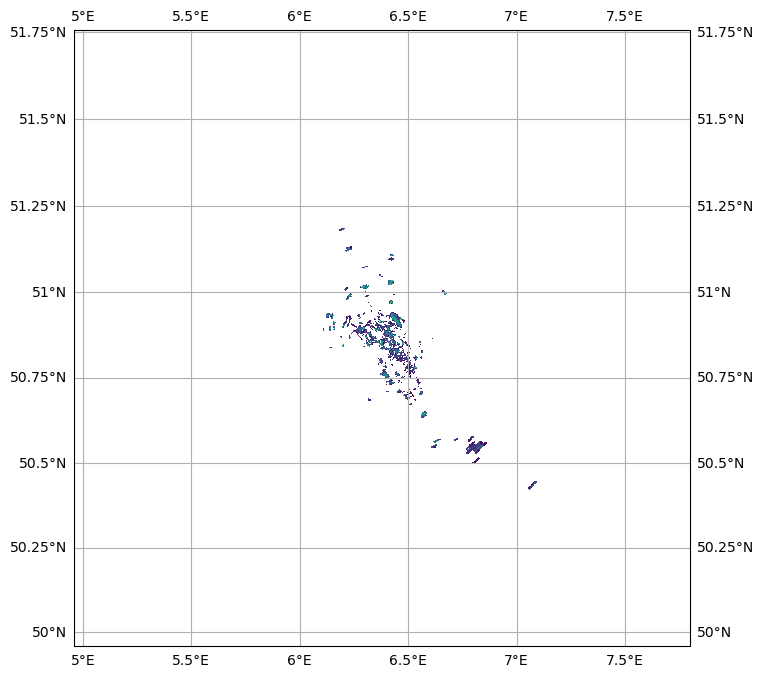

In [12]:
import cartopy.feature as cfeature


def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="physical", name="coastline", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = swp.DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

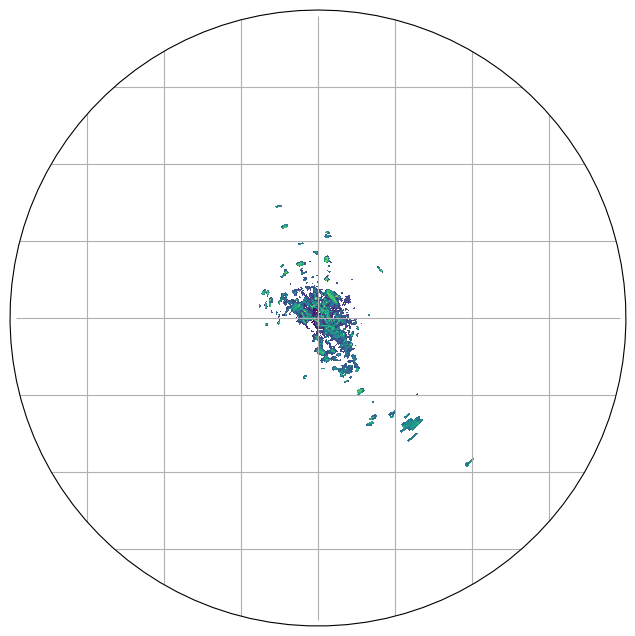

In [13]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

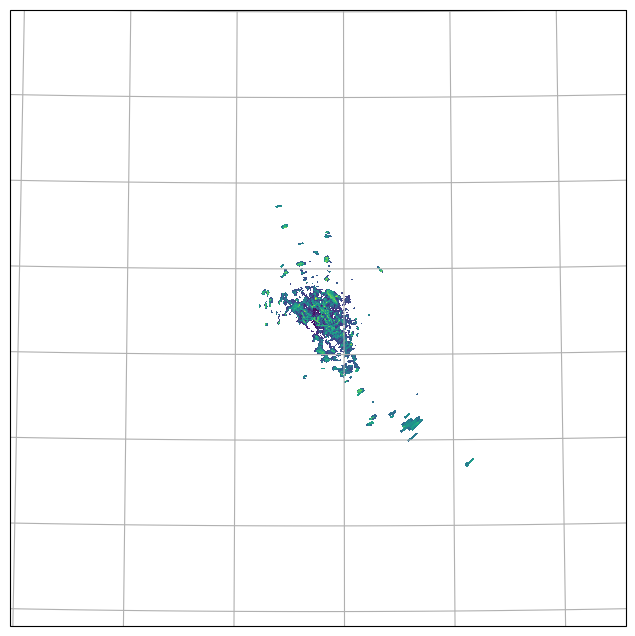

In [14]:
fig = pl.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

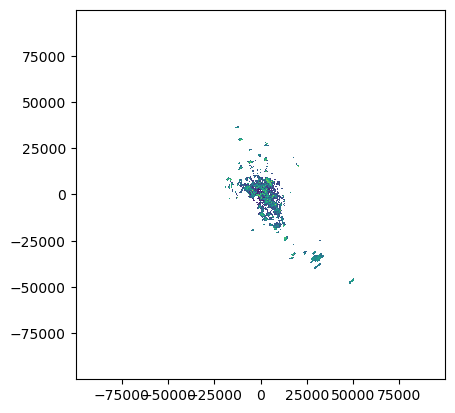

In [15]:
swp.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset.

In [16]:
display(swp.DBZH)

<xarray.DataArray 'DBZH' (azimuth: 361, range: 400)>
array([[24.5, 21. ,  1.5, ...,  nan,  nan,  nan],
       [25.5, 22.5,  0. , ...,  nan,  nan,  nan],
       [25.5, 22. , -3. , ...,  nan,  nan,  nan],
       ...,
       [24. , 30. , -5.5, ...,  nan,  nan,  nan],
       [25.5, 29.5, -5.5, ...,  nan,  nan,  nan],
       [24.5, 23. , 22. , ...,  nan,  nan,  nan]], dtype=float32)
Coordinates: (12/15)
  * azimuth     (azimuth) float64 0.5492 1.505 2.549 3.516 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 0.6 0.6 0.6 0.6 0.6 ... 0.6 0.6 0.6 0.6 0.6
  * range       (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    rtime       (azimuth) datetime64[ns] 2013-05-10T00:00:15.530303500 ... 20...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.38
    ...          ...
    x           (azimuth, range) float64 1.198 3.594 5.99 ... -859.6 -861.8
    y           (azimuth, range) float64 125.0 375.0 ... 9.96e+04 9.985e+04
    z           (azimuth, range) float64 118.0 120.6 ... 1.744e+03 1.75e+03
    gr          (azimuth, range) float64 124.8 374.7 ... 9.96e+04 9.985e+04
    rays        (azimuth, range) float64 0.5492 0.5492 0.5492 ... 359.5 359.5
    bins        (azimuth, range) float32 125.0 375.0 ... 9.962e+04 9.988e+04
Attributes:
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('rtime')` method, which sorts the radials by time.

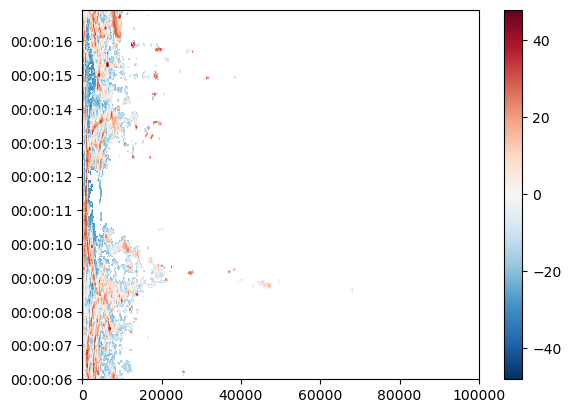

In [17]:
swp.DBZH.sortby("rtime").plot(x="range", y="rtime", add_labels=False)

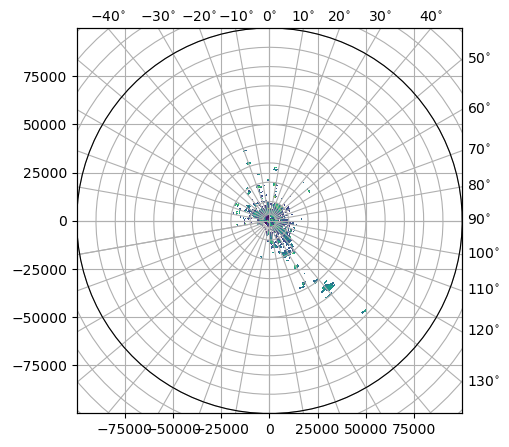

In [18]:
fig = pl.figure(figsize=(5, 5))
pm = swp.DBZH.wradlib.plot_ppi(proj={"latmin": 3e3}, fig=fig)

### Mask some values

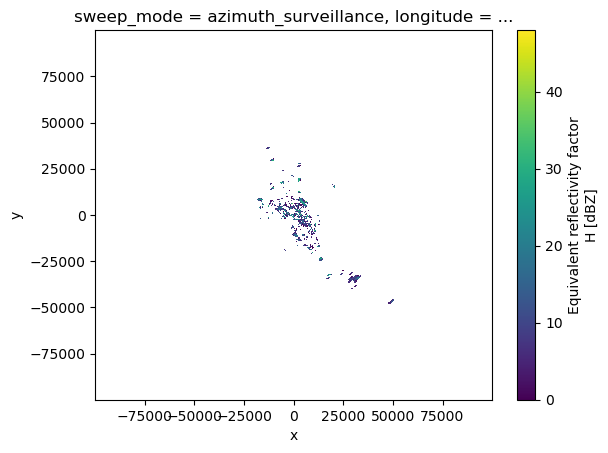

In [19]:
dbzh = swp["DBZH"].where(swp["DBZH"] >= 0)
dbzh.plot(x="x", y="y")

In [20]:
vol[0]

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5492 1.505 2.549 ... 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    rtime              (azimuth) datetime64[ns] 2013-05-10T00:00:15.530303500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2013-05-10T00:00:06.015151500
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.6
Attributes:
    fixed_angle:  0.6

### Export to ODIM and CfRadial2

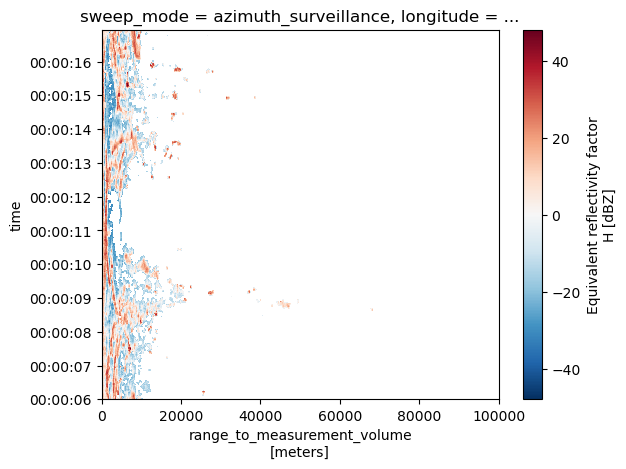

In [21]:
vol[0].DBZH.sortby("rtime").plot(y="rtime")

In [22]:
vol.to_odim("rainbow_as_odim.h5")
vol.to_cfradial2("rainbow_as_cfradial2.nc")

### Import again

<xarray.Dataset>
Dimensions:              (sweep: 14)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2013-05-10T00:00:06Z'
    time_coverage_end    <U20 '2013-05-10 00:03:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_13'
    sweep_fixed_angle    (sweep) float64 0.6 1.4 2.4 3.5 ... 17.9 21.3 25.4 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.6

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5492 1.505 2.549 ... 358.5 359.5
    elevation          (azimuth) float64 ...
    rtime              (azimuth) datetime64[ns] 2013-05-10T00:00:15.530303488...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2013-05-10T00:00:06.015151616
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.6
Attributes:
    fixed_angle:  0.6

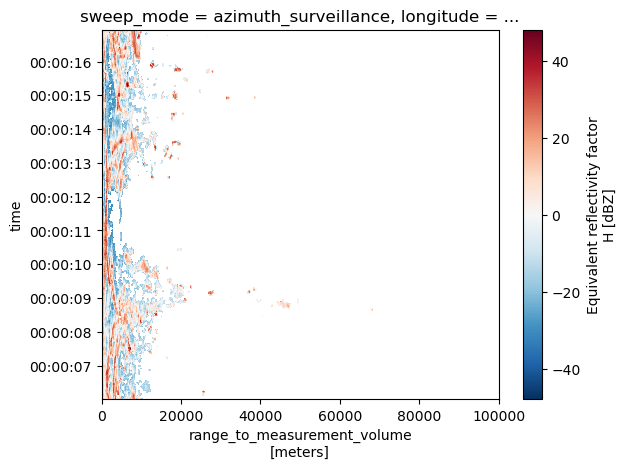

In [23]:
vola = wrl.io.open_odim_dataset(
    "rainbow_as_odim.h5", reindex_angle=False, keep_elevation=True
)
display(vola.root)
display(vola[0])
vola[0].DBZH.sortby("rtime").plot(y="rtime")

<xarray.Dataset>
Dimensions:              (sweep: 14)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2013-05-10T00:00:06Z'
    time_coverage_end    <U20 '2013-05-10 00:03:15Z'
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_group_name     (sweep) <U8 'sweep_0' 'sweep_1' ... 'sweep_13'
    sweep_fixed_angle    (sweep) float64 0.6 1.4 2.4 3.5 ... 17.9 21.3 25.4 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.6

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5492 1.505 2.549 ... 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    rtime              (azimuth) datetime64[ns] 2013-05-10T00:00:15.530303500...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2013-05-10T00:00:06.015151500
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           object ...
    follow_mode        object ...
    sweep_fixed_angle  float64 0.6
Attributes:
    fixed_angle:  0.6

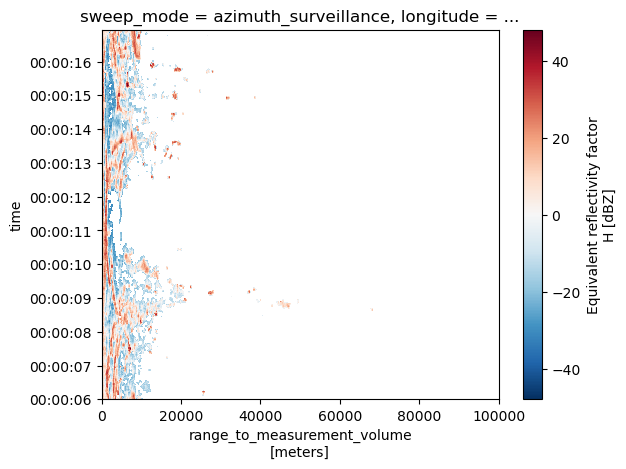

In [24]:
volb = wrl.io.open_cfradial2_dataset("rainbow_as_cfradial2.nc")
display(volb.root)
display(volb[0])
volb[0].DBZH.sortby("rtime").plot(y="rtime")

### Check equality

We have to sort accordingly and drop the time variables when checking equality.

In [25]:
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(
    vol[0].drop(["rtime", "time"]), vola[0].drop(["rtime", "time"])
)
xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_allclose(
    vol[0].drop(["rtime", "time"]), volb[0].drop(["rtime", "time"])
)
xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(
    vola[0].drop(["rtime", "time"]), volb[0].drop(["rtime", "time"])
)

## More Rainbow5 loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group

<div class="alert alert-warning">

**Warning** <br>
    
Since $\omega radlib$ version 1.18 the xarray backend engines for polar radar data have been renamed and prepended with `wradlib-` (eg. `rainbow` -> `wradlib-rainbow`). This was necessary to avoid clashes with the new [xradar](https://github.com/openradar/xradar)-package, which will eventually replace the wradlib engines. Users have to make sure to check which engine to use for their use-case when using `xarray.open_dataset`. Users might install and test `xradar`, and check if it is already robust enough for their use-cases (by using xradar's `engine="rainbow"`.
    
Since $\omega radlib$ version 1.19 the xarray backend engines for polar radar data have been deprecated. The functionality is kept until wradlib version 2.0, when the backend-code will be removed completely. wradlib is importing that functionality from [xradar](https://github.com/openradar/xradar)-package whenever and wherever necessary.

Below we use a compatibility layer in wradlib to give users the chance to adapt their code. The first minimal change is that for every backend the group-layout is conforming to the CfRadial-standard naming scheme (``sweep_0``, ``sweep_1``, etc.).
    
</div>

Below you can inspect the main differences of the wradlib compatibility layer and the plain xradar implementation.

### use wradlib compatibility layer

In [26]:
swp_a = xr.open_dataset(
    f,
    engine="wradlib-rainbow",
    group="sweep_5",
    backend_kwargs=dict(reindex_angle=False),
)
display(swp_a)

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5052 1.516 2.51 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    rtime              (azimuth) datetime64[ns] ...
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] ...
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...
Attributes:
    fixed_angle:  6.3

### use xradar-backend

In [27]:
swp_b = xr.open_dataset(
    f, engine="rainbow", group="sweep_5", backend_kwargs=dict(reindex_angle=False)
)
display(swp_b)

<xarray.Dataset>
Dimensions:            (azimuth: 361, range: 400)
Coordinates:
  * azimuth            (azimuth) float64 0.5052 1.516 2.51 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 ...
  * range              (range) float32 125.0 375.0 625.0 ... 9.962e+04 9.988e+04
    time               (azimuth) datetime64[ns] ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables:
    DBZH               (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...